# Subocean and CTD data merging + correction
The goal of this notebook is to show how the subocean data is currently beeing processed, and to have a base for asking the questions


In [46]:
import numpy as np
import pandas as pd
import os 
import glob
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

In [47]:
# List subfolders
ctd_path = "C:/Users/cruz/Documents/SENSE/CTD_processing/data/Level1/Forel-GroupedStn"
subocean_path = "C:/Users/cruz/Documents/SENSE/SubOcean/data/Level2/L2B/Forel-GroupedStn"

In [48]:
subfolders = [f.path for f in os.scandir(ctd_path) if f.is_dir()]

print("Available subfolders:")
folderlist = []
for folder in subfolders:
    sub_folders = folder.split("/")[-1]
    sub_folders = sub_folders.split("\\")[-1]
    print(f"- {sub_folders}")
    folderlist.append(sub_folders)
 

Available subfolders:
- StnF0
- StnF1
- StnF2
- StnF3
- StnF4
- StnF5


## Select one of these subfolders, one correction at a time

In [49]:
subfolder = folderlist[1]

In [50]:
directory_ctd = os.path.join(ctd_path, subfolder)
directory_subocean = os.path.join(subocean_path, subfolder)
ctd_file = glob.glob(directory_ctd + "/*.csv")
subocean_file = glob.glob(directory_subocean + "/*.nc")

print(f"CTD file: {ctd_file}")
print(f"SubOcean file: {subocean_file}")

subocean_file_name = subocean_file[0]
ctd_file_name = ctd_file[0]

CTD file: ['C:/Users/cruz/Documents/SENSE/CTD_processing/data/Level1/Forel-GroupedStn\\StnF1\\2024-07-04T024636 SBE0251267.csv']
SubOcean file: ['C:/Users/cruz/Documents/SENSE/SubOcean/data/Level2/L2B/Forel-GroupedStn\\StnF1\\L2B_SubOceanExperiment2024_07_04T10_39_29.nc', 'C:/Users/cruz/Documents/SENSE/SubOcean/data/Level2/L2B/Forel-GroupedStn\\StnF1\\L2B_SubOceanExperiment2024_07_04T15_39_33.nc']


If multiple subocean file, change the file number below (instead of 0 put 1)

Open the two datasets (subocean and ctd data)

In [51]:
subocean_ds = xr.open_dataset(subocean_file_name)
ctd_df = pd.read_csv(ctd_file_name)
ctd_ds = ctd_df.to_xarray()

In [55]:
ctd_df.columns

Index(['scan', 'pressure_dbar', 'depth_m', 'temperature_C',
       'conductivity_mS_per_m', 'salinity_psu_seabird',
       'oxygen_saturation_ml_L', 'oxygen_saturation_percent', 'ph',
       'turbidity_NTU', 'cdom_mg_m3', 'fluorescence_mg_m3', 'flag',
       'pot_temp_C', 'density_kg_m3', 'o2_solubility_mll_seabird',
       'o2_solubility_mgl_seabird', 'o2_mgkg_seabird', 'o2_mgl_seabird', 'N2',
       'salinity_psu', 'is_downcast'],
      dtype='object')

In [52]:
interpolation_column = "datetime"
#Check if the datetime column is in the CTD dataset and in the subocean dataset
if interpolation_column in ctd_ds:
    print(f"CTD dataset has the column {interpolation_column}")
else:
    print(f"CTD dataset does not have the column {interpolation_column}")
if interpolation_column in subocean_ds:
    print(f"SubOcean dataset has the column {interpolation_column}")
else:
    print(f"SubOcean dataset does not have the column {interpolation_column}")

CTD dataset does not have the column datetime
SubOcean dataset has the column datetime


# Section 1: Preprocessing

We work with xarray as it'better for multidimensional data and interpolation, but it need some standardization on variable names

We would like to make a match between the ctd and the subocean data, for that, we choose the pressure to be our matching coordinates variable. The profiles might not be done at the same time but can still be used.

In [53]:
# prompt: Set the depth as coordinates of ctd_ds and subocean_ds and remove the original index

# Set 'Depth' as coordinate for both datasets and remove the original index
ctd_ds = ctd_ds.swap_dims({'index': 'datetime'})
ctd_ds = ctd_ds.set_coords('datetime')
ctd_ds = ctd_ds.drop_vars('index')

type: These variables cannot be found in this dataset: ['datetime']

In [ ]:
ctd_ds["datetime"] = pd.to_datetime(ctd_ds["datetime"])

In [ ]:

ctd_interpolated = ctd_ds.interp(datetime=subocean_ds["datetime"])

In [ ]:
merged_ds = xr.merge([subocean_ds, ctd_interpolated], compat='override')

In [ ]:
merged_ds

<xarray.Dataset>
Dimensions:                                          (datetime: 5258)
Coordinates:
  * datetime                                         (datetime) datetime64[ns] ...
Data variables: (12/66)
    Date                                             (datetime) object ...
    Time                                             (datetime) object ...
    Date_calibrated                                  (datetime) object ...
    Time_calibrated                                  (datetime) object ...
    CH4_dissolved_with_water_vapour_ppm              (datetime) float64 ...
    CH4_dissolved_with_water_vapour_nmol_L           (datetime) float64 ...
    ...                                               ...
    density_kg_m3                                    (datetime) float64 nan ....
    o2_solubility_mll_idronaut                       (datetime) float64 nan ....
    o2_solubility_mgl_idronaut                       (datetime) float64 nan ....
    o2_mgkg_idronaut                                 (datetime) float64 nan ....
    o2_mgl_idronaut                                  (datetime) float64 nan ....
    N2                                               (datetime) float64 nan ....
Attributes:
    concentration_cal1:          p0_123
    concentration_cal2:          p27_141
    title:                       SubOceanExperiment2024_07_03T12_47_08
    start_time:                  p2024_07_03_12_47_08
    end_time:                    p2024_07_03_15_17_19
    hydrostatic_pressure_coef1:  p400_0
    hydrostatic_pressure_coef2:  p0_0
    latitude:                    p0_0
    gas_type:                    False
    expedition_name:             Forel_GroupedStn

type: array of sample points is empty

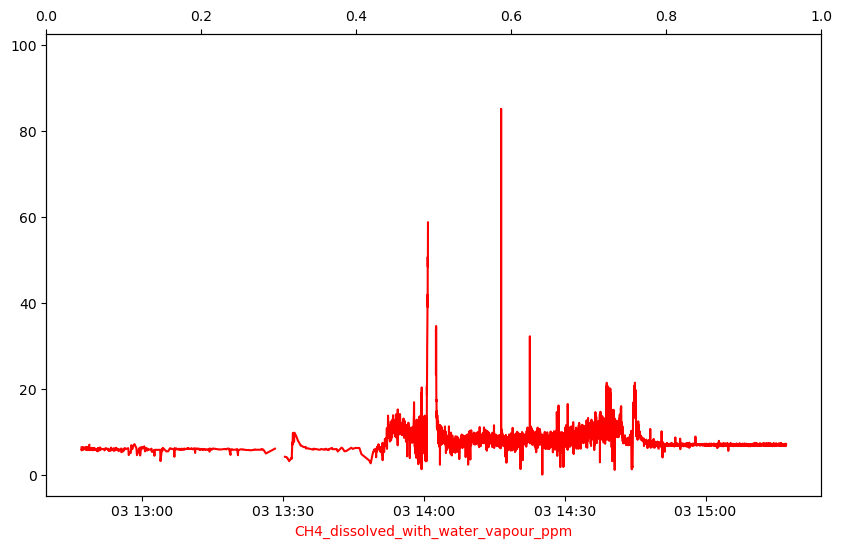

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Hydrostatic_Pressure_Calibrated_bar on the y-axis (reversed)
ax1.plot( merged_ds.datetime, merged_ds.CH4_dissolved_with_water_vapour_ppm, color='r')
ax1.set_xlabel('CH4_dissolved_with_water_vapour_ppm', color='r')
# Create a second x-axis
ax2 = ax1.twiny()
ax2.plot(merged_ds.pot_temp_C, merged_ds.pressure_dbar, color='g')

# Display the plot
plt.title('Hydrostatic Pressure vs. Temp and CH4')
plt.show()


# Seciton 2: CTD correction !

In [ ]:
def calc_meff_CH4(salinity: xr.DataArray=34, temperature: xr.DataArray=20, oxygen_pct: xr.DataArray=21) -> xr.DataArray:
  """
  Calculate membrane enrichment factor for CH4.
  Formula: meff_CH4 = (1.9774+(0.0385-0.00316*S)*(T-2.67))*(1+0.2286*(O2-0.2)/(0-0.2))

  Args:
      salinity (xr.DataArray): Salinity in PSU
      temperature (xr.DataArray): Water temperature in °C
      oxygen_pct (xr.DataArray): Dissolved oxygen in %

  Returns:
      xr.DataArray: Membrane enrichment factor (dimensionless)
  """
  BASE = 1.9774
  TEMP_COEF = 0.0385
  SAL_TEMP_COEF = -0.00316
  TEMP_OFFSET = 2.67
  O2_COEF = 0.2286
  O2_THRESHOLD = 0.2

  temp_component = (TEMP_COEF + SAL_TEMP_COEF * salinity) * (temperature - TEMP_OFFSET)
  o2_component = 1 + O2_COEF * (oxygen_pct - O2_THRESHOLD)/(0 - O2_THRESHOLD)

  return (BASE + temp_component) * o2_component


## a) Standard values recalculation check



Salinity = 34, temperature = 20 °C, DO = 0.21

In [ ]:
meff = calc_meff_CH4(34,20,0.21)
#Convert the float into a dimensional data (constant with pressure)
meff = meff +(merged_ds["CH4_measured_ppm"]*np.zeros(len(merged_ds["CH4_measured_ppm"])))
meff.attrs['units'] = 'dimensionless'
meff.attrs['long_name'] = 'Membrane enrichment factor for CH4 with standard values'


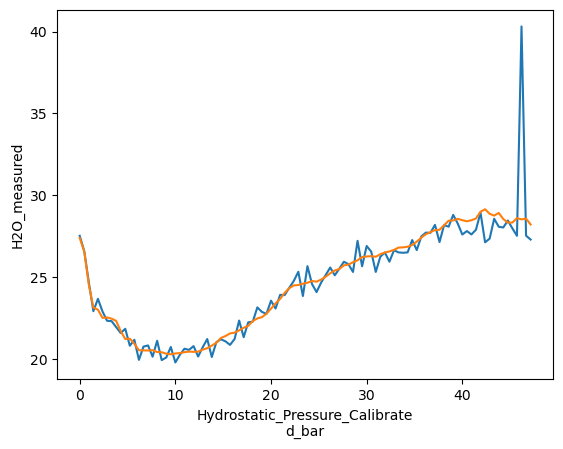

In [ ]:
merged_ds["H2O_measured_no_moving_average"].plot()
merged_ds["H2O_measured"].plot()

In [ ]:
Cgas.plot()

type: name 'Cgas' is not defined

In [ ]:
merged_ds['meff_CH4_standard'] = meff
# Calculate membrane enrichment factor
Cgas = merged_ds["CH4_measured_ppm"]
Qcg = merged_ds["Flow_Carrier_Gas_sccm"]
Qtot = merged_ds["Total_Flow_sccm"]
C_h2o = merged_ds["H2O_measured"]/100

merged_ds["CH4_dissolved_with_water_vapor_ppm_standard_recalculated"] = 1/merged_ds["meff_CH4_standard"] * Cgas/(1-Qcg/Qtot - C_h2o)

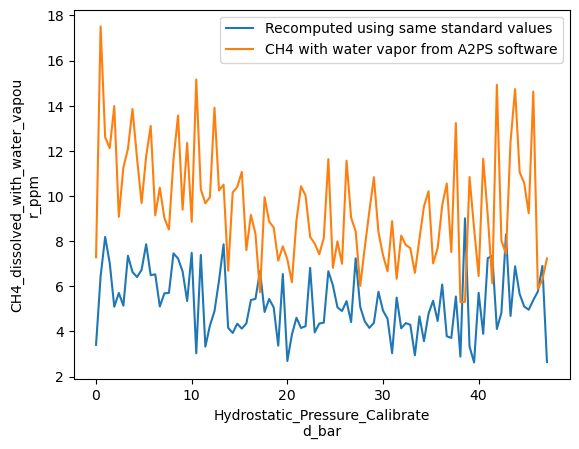

In [ ]:
merged_ds["CH4_dissolved_with_water_vapor_ppm_standard_recalculated"].plot(label="Recomputed using same standard values")
merged_ds["CH4_dissolved_with_water_vapour_ppm"].plot(label="CH4 with water vapor from A2PS software")
#Set y limits from 0 to 10
plt.legend()


## b) Using CTD data:

In [ ]:
meff = calc_meff_CH4(
  salinity=merged_ds['Sal'],
  temperature=merged_ds['Temp'],
  oxygen_pct=merged_ds['O2%']/100*0.21
        )
meff.attrs['units'] = 'dimensionless'
meff.attrs['long_name'] = 'Membrane enrichment factor for CH4 corrected with ctd profile'

In [ ]:
merged_ds['meff_CH4_ctd_correction'] = meff
merged_ds["CH4_dissolved_with_water_vapor_ctd_correction"] = 1/merged_ds["meff_CH4_ctd_correction"] * Cgas/(1-Qcg/Qtot - C_h2o)

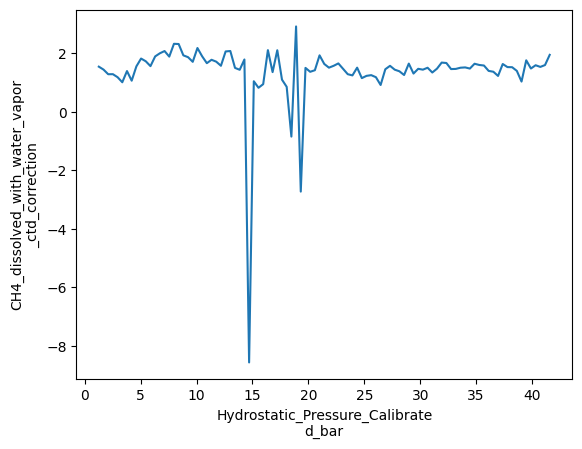

In [ ]:

merged_ds["CH4_dissolved_with_water_vapor_ctd_correction"].plot()

# Section 3: Convert into dissolved methane in water

I could not find the equation yet to solve this aspect (the equation below shows bad results)

In [ ]:
def calc_dissolved_CH4(ch4_gas_ppm: xr.DataArray,
                            temperature_c: xr.DataArray,
                            salinity: xr.DataArray,
                            pressure_bar: xr.DataArray) -> xr.DataArray:
    """
    Calculate dissolved methane concentration at 200m depth using Henry's law with pressure correction.

    Args:
        ch4_gas_ppm (xr.DataArray): CH4 concentration in gas phase (ppm)
        temperature_c (xr.DataArray): Water temperature (°C)
        salinity (xr.DataArray): Salinity (PSU)
        pressure_bar (xr.DataArray): Pressure at 200m depth (bar)

    Returns:
        xr.DataArray: Dissolved CH4 concentration (nmol/L)
    """
    # Convert temperature to Kelvin
    temperature_k = temperature_c + 273.15

    # Convert pressure to atm
    pressure_atm = pressure_bar *0.986923  / 1013.25

    # Weiss (1974) coefficients for methane solubility in seawater (mol/kg/atm)
    A1 = -68.8862
    B1 = 101.4956
    C1 = 28.7314

    # Calculate Henry's constant for methane (mol/kg/atm)
    henry_constant = np.exp(A1 + (B1 / temperature_k) + C1 * np.log(temperature_k)) * np.exp(-0.0432 * salinity)

    # Convert Henry's constant from mol/kg/atm to mol/L/atm (approximation for seawater density ~1 kg/L)
    henry_constant_mol_L_atm = henry_constant  # Since 1 kg ~ 1 L for seawater

    # Fugacity coefficient for methane (approximation, near 1 at low pressure, correct at high pressure)
    # Using a simple Peng-Robinson-type approximation
    fugacity_coefficient = 1 - (pressure_atm * 0.0001)  # Approximate correction factor
    fugacity_coefficient = np.maximum(fugacity_coefficient, 0.8)  # Avoid unphysical values

    # Calculate methane fugacity
    methane_fugacity = pressure_atm * fugacity_coefficient

    # Calculate dissolved methane concentration (mol/L)
    ch4_dissolved_mol_L = (ch4_gas_ppm / 1e6) * methane_fugacity / henry_constant_mol_L_atm

    # Convert to nmol/L
    ch4_dissolved_nmol_L = ch4_dissolved_mol_L * 1e9

    return ch4_dissolved_nmol_L

In [ ]:
CH4 = 4 #ppm
Temp = 3 # °C
Sal = 33
Pressure = 20
calc_dissolved_CH4(CH4, Temp, Sal, Pressure)

1.3506662130821136e-38

In [ ]:
merged_ds["CH4_nmol_L_dissolved_with_water_vapor_standard"] = calc_dissolved_CH4(merged_ds["CH4_dissolved_with_water_vapor_ppm_standard_recalculated"],
                                                                                 merged_ds["Temp"], merged_ds["Sal"],
                                                                                 merged_ds["Hydrostatic_Pressure_Calibrated_bar"]*1000) #Pressure in mbar

(0.0, 10.0)

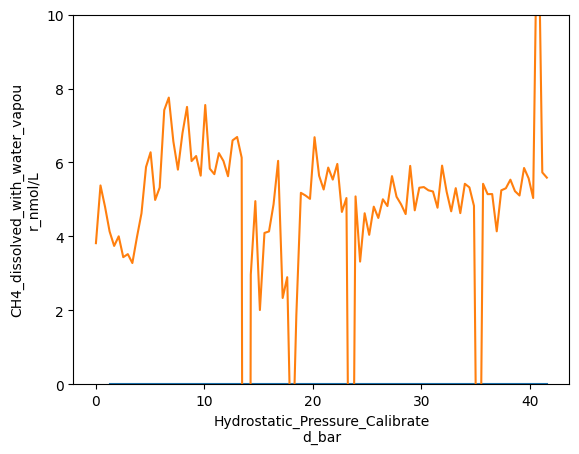

In [ ]:
merged_ds["CH4_nmol_L_dissolved_with_water_vapor_standard"].plot()
merged_ds["CH4_dissolved_with_water_vapour_nmol/L"].plot()
plt.ylim(0,10)

In [ ]:
merged_ds["CH4_nmol_L_dissolved_with_water_vapor_ctd_correction"] = calc_dissolved_CH4(merged_ds["CH4_dissolved_with_water_vapor_ctd_correction"],
                                                                                       merged_ds["Temp"], merged_ds["Sal"], merged_ds["Hydrostatic_Pressure_Calibrated_bar"])

In [ ]:
file_name = "MERGED_CTD_SUBOCEAN.nc"
merged_ds.to_netcdf(file_name)

In [ ]:
#Convert merged_ds to dataframe 
merged_df = merged_ds.to_dataframe()


In [ ]:
#Get the init

In [ ]:
merged_df.to_csv("MERGED_CTD_SUBOCEAN.csv")

In [ ]:
merged_df.reset_index()

,Hydrostatic_Pressure_Calibrated_bar,CH4_dissolved_with_water_vapour_ppm,CH4_dissolved_with_water_vapour_nmol_L,CH4_dissolved_with_constant_dry_gas_flow_ppm,CH4_dissolved_with_constant_dry_gas_flow_nmol_L,C2H6_dissolved_ppm,Delta_13_CH4_per_mille,Depth_meter,CH4_measured_ppm,H2O_measured,...,oxygen_saturation_percent,oxygen_concentration_ppm,pH,PAR,Chl(a)Phy-EthrinPhy-Cyanin,pot_temp_C,density_kg_m3,o2_sol_mll_idronaut,o2_sol_mgl_idronaut,N2
0,0.000000,7.284201,8.076092,17.314750,19.197109,1.700897,364.746669,0.000000,0.504306,27.392408,...,102.800000,10.430000,9.173000,739.684450,8.710000,6.738000,1017.934279,7.225130,10.325072,0.087047
1,0.476299,17.512839,19.416703,18.673751,20.703847,2.619076,-65.616456,4.736768,0.512494,26.555431,...,103.004128,10.572890,8.176855,742.224212,66.403416,6.148747,1018.366527,7.301640,10.434409,0.082431
2,0.952598,12.603077,13.973210,14.430423,15.999290,1.401414,-51.475293,9.473432,0.642622,24.535193,...,102.847402,10.665260,7.473242,748.562850,49.034336,5.635394,1018.780917,7.366268,10.526765,0.033977
3,1.428897,12.120317,13.438003,14.120970,15.656136,3.231299,304.285076,14.209965,0.558348,23.136823,...,102.171103,10.607110,7.422564,758.552167,37.412120,5.491317,1018.929494,7.382445,10.549883,0.002575
4,1.905196,13.983780,15.504059,16.760213,18.582316,1.774484,428.638978,18.946397,0.396984,23.007673,...,101.746103,10.564610,7.482675,756.529417,6.660000,5.479858,1018.944094,7.383557,10.551473,-0.002461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45.248404,9.233676,10.237482,10.039948,11.131421,0.775907,-86.782209,449.506330,0.347960,28.330108,...,109.849772,12.024932,8.291498,221.481366,5.169863,2.373432,1022.463438,7.729704,11.046133,0.017171
96,45.724703,14.627473,16.217703,13.101231,14.525507,2.966275,-356.845567,454.233084,0.308351,28.599783,...,110.024703,12.064941,8.292165,219.274299,4.966231,2.295525,1022.513424,7.741649,11.063203,0.003491
97,46.201002,5.886161,6.526074,5.600216,6.209044,2.795369,2000.325450,458.959420,0.348226,28.523198,...,110.199499,12.099950,8.293000,217.487960,4.901303,2.269826,1022.536981,7.745084,11.068112,-0.006781
98,46.677301,6.293417,6.977600,6.606297,7.324488,3.004774,-384.137505,463.685965,0.436242,28.569985,...,110.722699,12.168405,8.295000,214.587647,5.069325,2.199217,1022.578435,7.756236,11.084049,-0.000827
